In [1102]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import zscore
from kneed import KneeLocator
from feature_engine import transformation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1103]:
data, true = make_blobs(
    n_samples=1000, 
    n_features=102,
    centers=5,
    shuffle=True,
    center_box=(0, 5),
    cluster_std=4,
    random_state=1
    )

df = pd.DataFrame(data);

def transform_column(col=pd.Series()) -> pd.Series:
    min = col.min()
    col = col.apply(lambda x : x - min)
    return col

# Form data to format we want
df = df.round(0)
df = df.apply(lambda x : transform_column(x))

In [1104]:
def add_constant(df = pd.DataFrame(), c = 1) -> pd.DataFrame:
    return df.map(lambda x: x + c)

# Removing outliers
org_df = df.copy()
df = df[(np.abs(zscore(df)) <= 3).all(axis=1)]
temp = pd.merge(org_df, df, how="outer", suffixes=("", "_y"), indicator=True)
temp = temp[temp['_merge']=='left_only'][org_df.columns].index.array
true = np.delete(true, temp)

# Yeojohnson transformation for each column
transformer = transformation.YeoJohnsonTransformer()
df = transformer.fit_transform(df)

# Standard scaling for all values
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df))

In [1105]:
# Silhoutte score
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
}

tested_range = range(2, 20)
silhouette_coefficients = []
sse = []
for k in tested_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
    silhouette_coefficients.append(silhouette_score(df, kmeans.labels_))

kl = KneeLocator(tested_range, sse, curve="convex", direction="decreasing")
print(f'The elbow point is {kl.elbow}')
print(f'Highest silhoutte score {np.max(silhouette_coefficients)} occurs at {np.argmax(silhouette_coefficients)+2}')

The elbow point is 5
Highest silhoutte score 0.04257743775146295 occurs at 5


c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

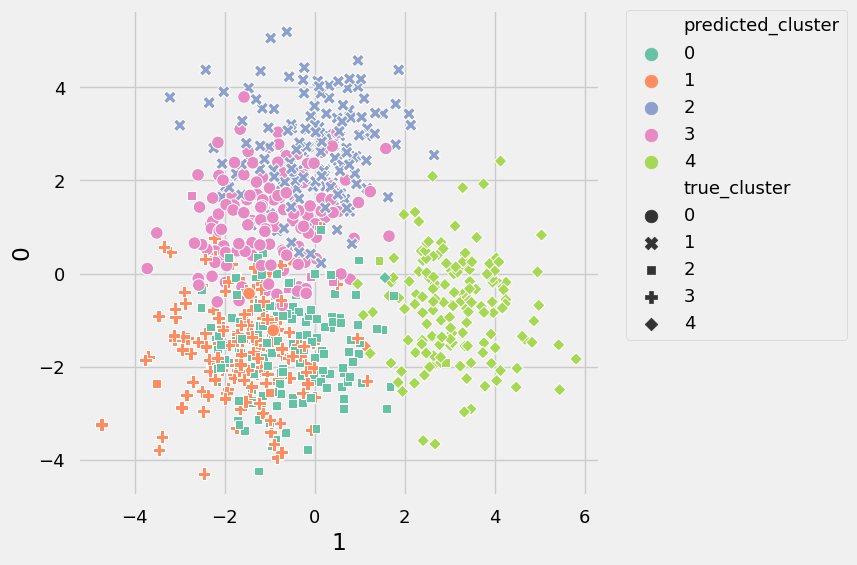

In [1106]:
# Doing the clustering
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
res = kmeans.fit(df).labels_
centers = kmeans.cluster_centers_

# Dimensionaltiy reduction to visualize the data
pca = PCA(n_components=2)
matrix = pca.fit_transform(df)
vis_df = pd.DataFrame(matrix)

# Plot for all data
plt.figure(figsize=(6, 6))

vis_df['predicted_cluster'] = res
vis_df['true_cluster'] = true

scat = sns.scatterplot(
    data=vis_df,
    x=1,
    y=0,
    hue='predicted_cluster',
    style='true_cluster',
    palette="Set2",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [1107]:
# Finding acuracy based on what we have
# incorrect_cnt = np.sum(true == res)
# accuracy = ((len(res) - incorrect_cnt) / len(res)) * 100
# print(f"The accuracy of this clustering is {accuracy.round(2)}%")

# Finding the five highest average tag counts in each cluster
clust_cnt = 5
clust_tag_avgs = []
for i in range(0, clust_cnt):
    idxs = np.where(res == i)[0]
    usr_count = len(idxs)
    tot_usr_count = len(res)
    # If we use the original df (raw counts) it becomes skewed 
    tag_avgs = df.iloc[idxs].sum().apply(lambda x: x / usr_count)
    clust_tag_avgs.append(tag_avgs)

# I need to calculate an array of tag weights for each cluster. 
# My idea is to adjust the values of each cluster row to sum up to 1 or 100%
# For this ill
#   Find smallest value and add to all values
#   Find sum of all values
#   Divide each element by the sum (and multipley by 100)
clust_tag_weights = []
for i in range(0, clust_cnt):
    min = np.min(clust_tag_avgs[i])
    temp = clust_tag_avgs[i].apply(lambda x: x - min)
    sum = temp.sum()
    temp = temp.apply(lambda x: x / sum)
    clust_tag_weights.append(temp)
print(pd.DataFrame(clust_tag_weights).max(axis=1))

0    0.017362
1    0.017069
2    0.018304
3    0.016961
4    0.018892
dtype: float64
